In [2]:
from pynq import Overlay
import pynq.lib.dma
import numpy as np
import random
import time
from pynq import Xlnk

# Load the overlay
overlay = Overlay('/home/xilinx/pynq/overlays/autoencoder/autoencoder.bit')

In [3]:
# Load the DMA and enc_dec classes
dma = overlay.enc_dec.enc_dec_dma
enc_dec_ip = overlay.enc_dec.encoder_decoder_0

In [4]:
# Write auto_restart (bit #7) to enc_dec ip ctrl register
enc_dec_ip.write(0x0, 0x81) 

In [5]:
# Generates N symbols. Can be either:
# [ 1 0 0 0 ] or
# [ 0 1 0 0 ] or
# [ 0 0 1 0 ] or
# [ 0 0 0 1 ]
def generate_random_data(N):
    label = np.random.randint(4, size=N)
    data = []
    for i in label:
        temp = np.zeros(4)
        temp[i] = 1 << 24
        data.append(temp)
    data = np.hstack(np.array(data).astype(int))
    return data

In [6]:
# Counts the number of errors between in_buffer and out_buffer
def count_error(in_buffer, out_buffer, Nsymbols):
    error_cnt = 0
    for sym_idx in range(Nsymbols):
        if (not np.array_equal(in_buffer[4*sym_idx:4*(sym_idx+1)], out_buffer[4*sym_idx:4*(sym_idx+1)])):
            #print('should be:', np.argmax(in_reshaped[sym_idx,]), '!= actual', np.argmax(out_reshaped[sym_idx,]))
            error_cnt += 1
    return error_cnt

In [7]:
# Generates a range vector (for range of SNRs)
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

# Performance (BER vs. SNR)

In [8]:
Nsymbols = 50000
print("Started generating ", Nsymbols, " samples...")
data_in = generate_random_data(Nsymbols)
print("Finished generating ", Nsymbols, " samples")

Started generating  50000  samples...
Finished generating  50000  samples


In [9]:
# Initiate vectors and timer
hw_exec_time_vec = np.zeros(Nsymbols)
errors_vec = np.zeros(Nsymbols)
start_time = time.time()
stop_time = time.time()
measure_self_time = stop_time - start_time

# Memory mapped registers
SNR_REG_ADDR       = 0x10
AWGN_MODE_REG_ADDR = 0x18

# Enable AWGN channel module
# 0 - AWGN enabled
# 1 - Loopback (encoder connected to decoder directly)
enc_dec_ip.write(AWGN_MODE_REG_ADDR, 0x0)

# Initiate buffers
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
np.copyto(in_buffer,data_in)

# Set SNR range
snr_range = list(frange(0.0, 8.5, 1/2))
ber_vec = np.zeros(len(snr_range))

# Loop over SNRs
for snr_idx in range(len(snr_range)):
    snr = snr_range[snr_idx]
    # SNR is ap_ufixed<8,4>, so for example 8.75 is 1000.1100 = 0x7C
    snr_ap_fixed_8_4 = int((snr * 2**4))
    enc_dec_ip.write(SNR_REG_ADDR, snr_ap_fixed_8_4)
    
    start_time = time.time()
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

    stop_time = time.time()
    hw_exec_time_vec[snr_idx] = (stop_time - start_time - measure_self_time) * 1000
    errs = (in_buffer != out_buffer)
    errs =  errs.astype(int).sum()/2
    ber_vec[snr_idx] = errs/Nsymbols
    print("SNR =  %.2f [dB] | BER = %.3f | exec time = %5.3f [ms]" % (snr, ber_vec[snr_idx], hw_exec_time_vec[snr_idx]))


SNR =  0.00 [dB] | BER = 0.150 | exec time = 109.883 [ms]
SNR =  0.50 [dB] | BER = 0.132 | exec time = 109.858 [ms]
SNR =  1.00 [dB] | BER = 0.112 | exec time = 109.860 [ms]
SNR =  1.50 [dB] | BER = 0.091 | exec time = 109.857 [ms]
SNR =  2.00 [dB] | BER = 0.076 | exec time = 109.870 [ms]
SNR =  2.50 [dB] | BER = 0.059 | exec time = 109.855 [ms]
SNR =  3.00 [dB] | BER = 0.046 | exec time = 109.857 [ms]
SNR =  3.50 [dB] | BER = 0.036 | exec time = 109.851 [ms]
SNR =  4.00 [dB] | BER = 0.025 | exec time = 109.869 [ms]
SNR =  4.50 [dB] | BER = 0.018 | exec time = 109.870 [ms]
SNR =  5.00 [dB] | BER = 0.012 | exec time = 109.874 [ms]
SNR =  5.50 [dB] | BER = 0.008 | exec time = 109.866 [ms]
SNR =  6.00 [dB] | BER = 0.005 | exec time = 109.873 [ms]
SNR =  6.50 [dB] | BER = 0.003 | exec time = 109.866 [ms]
SNR =  7.00 [dB] | BER = 0.002 | exec time = 109.858 [ms]
SNR =  7.50 [dB] | BER = 0.001 | exec time = 109.850 [ms]
SNR =  8.00 [dB] | BER = 0.000 | exec time = 109.860 [ms]


In [10]:
# Results from CPU run
BER_vec_from_x86 = np.array([0.15322, 0.13234, 0.11066, 0.0914, 0.0752, 0.05912, 0.04642, 0.03584, 0.02562, 0.0192, 0.0115, 0.00842, 0.00532, 0.00322, 0.00146, 0.00104, 0.00038])
SNR_vec_from_x86 = np.array([0.0,     0.5,     1.0,     1.5,    2.0,    2.5,     3.0,     3.5,     4.0,     4.5,     5.0,   5.5,     6.0,     6.5,     7.0,     7.5,     8.0])

## BER vs. SNR

In [11]:
import matplotlib.pyplot as plt
# BER as function of SNR
# %matplotlib inline
plt.plot(snr_range[0:len(SNR_vec_from_x86)], ber_vec[0:len(BER_vec_from_x86)], 'bo', label='PYNQ')
plt.yscale('log')
plt.plot(SNR_vec_from_x86, BER_vec_from_x86, 'ro', label='CPU (x86)')
plt.xlabel('SNR [dB]')
plt.ylabel('BER')
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.legend(loc='upper right',ncol = 1)
plt.rcParams['figure.figsize'] = (8,6)
plt.show()

<Figure size 640x480 with 1 Axes>

# Acceleration

In [12]:
mean_sw_time_x86 = np.array([
        1.33718252,   2.48003006,   4.728055  ,   5.84330559,
         8.58491659,  12.78574467,  14.53801394,  18.90070438,
        22.55301476,  25.4357934 ,  28.84516716,  32.89698362,
        37.28247881,  41.18812084,  42.68226624,  46.46191597,
        49.51156378,  52.9309392 ,  58.74325037,  61.30627394,
        66.55865908,  68.87162924,  71.54535055,  77.36371756,
        82.05834627,  82.76798725,  85.5718255 ,  88.1354332 ,
        92.7267909 ,  99.04347658, 103.23832035, 105.39360046,
       107.30762482, 110.28927565, 114.98961449, 118.9084053 ,
       122.89119959, 124.81124401, 128.98906469, 132.92633295,
       134.45657492, 140.55957794, 143.01980734, 148.7409234 ,
       150.6405592 , 157.7855587 , 158.46712589, 159.66328382,
       166.34050608, 171.93937302, 177.63944864, 174.51050282,
       179.4383049 , 186.94297075, 191.83291197, 194.44311857,
       203.51091623, 198.85662794, 201.02648735, 205.26673794,
       209.74487066, 214.92580175, 216.94688797, 222.54804373,
       224.261415  , 223.70918989, 229.85544205, 241.71677828,
       244.21242476, 251.25153065, 249.23024178, 255.71408272,
       258.42586756, 259.0318203 , 263.97647858, 276.93678141,
       273.61328602, 276.53441429, 281.02831841, 285.98189354,
       285.96547842, 295.13555765, 292.71230698, 297.64024019,
       298.95777702, 301.28616095, 305.00073433, 307.49310255,
       313.79945278, 315.30951262, 323.32295179, 325.84770918,
       327.21458673, 331.70620203, 336.77486181, 339.91520405,
       344.21472549, 342.57872105, 352.11946964, 358.3812356 ,
       351.42768621, 362.97090054])

In [13]:
# Nsymbols = np.floor(np.linspace(10, 1250, 50)).astype(int)
Ntests = 20
Nsymbols = np.concatenate((np.arange(start=10, stop=200, step=50), 
                           np.arange(start=200, stop=10000, step=100)), axis=0)
print(Nsymbols)
hw_exec_time_vec = np.zeros((Ntests, len(Nsymbols)))
start_time = time.time()
stop_time = time.time()
measure_self_time = stop_time-start_time

for test_id in range(Ntests):
    for y in range(len(Nsymbols)):
        data_in = generate_random_data(Nsymbols[y])
        in_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
        out_buffer = xlnk.cma_array(shape=(len(data_in),), dtype=np.int32)
        np.copyto(in_buffer,data_in)    
        start_time = time.time()
        dma.sendchannel.transfer(in_buffer)
        dma.recvchannel.transfer(out_buffer)
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        stop_time = time.time()
        hw_exec_time_vec[test_id,y] = (stop_time-start_time-measure_self_time)*1000

[  10   60  110  160  200  300  400  500  600  700  800  900 1000 1100
 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500
 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900
 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300
 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700
 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100
 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500
 9600 9700 9800 9900]


In [14]:
mean_hw_exec_time_vec = np.mean(hw_exec_time_vec, axis=0)

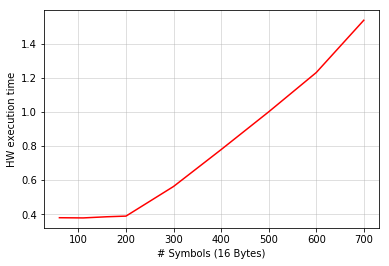

In [15]:
plt.plot(Nsymbols[1:10], mean_hw_exec_time_vec[1:10], 'r')
plt.xlabel('# Symbols (16 Bytes)')
plt.ylabel('HW execution time')
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
# plt.legend(loc='upper right',ncol = 1)
plt.rcParams['figure.figsize'] = (8,6)
plt.show()

Text(0,0.5,'Execution time [ms]')

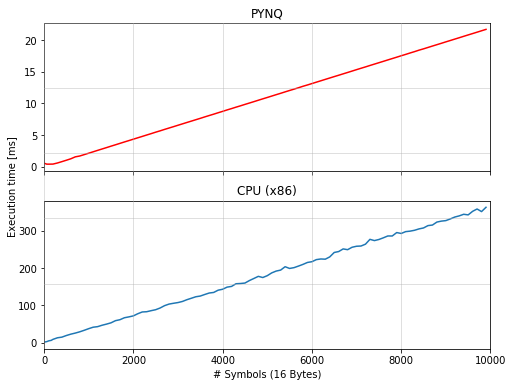

In [16]:
# Execution time as function of data length
fig, axarr = plt.subplots(2, sharex=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axarr[0].plot(Nsymbols, mean_hw_exec_time_vec, 'r')
axarr[0].set_title('PYNQ')
axarr[0].set_xlim(1,10000)
axarr[1].plot(Nsymbols, mean_sw_time_x86)
axarr[1].set_title('CPU (x86)')
axarr[1].set_xlim(1,10000)
plt.grid(which='minor', alpha=0)
plt.grid(which='major', alpha=0.5)
plt.xlabel('# Symbols (16 Bytes)')
plt.ylabel('Execution time [ms]')

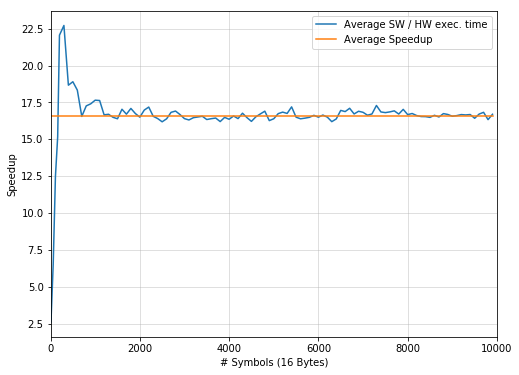

In [17]:
plt.plot(Nsymbols, mean_sw_time_x86/mean_hw_exec_time_vec, label='Average SW / HW exec. time')
plt.plot(Nsymbols, np.ones(len(Nsymbols))*np.mean(mean_sw_time_x86/mean_hw_exec_time_vec), label='Average Speedup')
plt.legend(loc='upper right',ncol = 1)
plt.xlabel('# Symbols (16 Bytes)')
plt.ylabel('Speedup')
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.xlim(1,10000)
# plt.legend(loc='upper right',ncol = 1)
plt.rcParams['figure.figsize'] = (8,6)
plt.show()

In [18]:
np.mean(mean_sw_time_x86/mean_hw_exec_time_vec)

16.552903247518366